In [61]:
from mmcv import Config
from openselfsup.models import build_model
from openselfsup.datasets import build_dataset
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np

In [62]:
cfg = Config.fromfile('/home/david/OpenSelfSup/az_configs/r50_256_bs32_ep300.py')

In [63]:
cfg.data.train.prefetch = True

In [64]:
dataset = build_dataset(cfg.data.train)

  0%|          | 3/10200 [00:00<10:37, 16.00it/s]

Loading 10200 images



100%|██████████| 10200/10200 [19:02<00:00,  8.93it/s] 


In [65]:
pair = dataset[0]['img']
v1, v2 = pair

In [69]:
dataloader = DataLoader(dataset, batch_size=32)

/home/david/torch/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


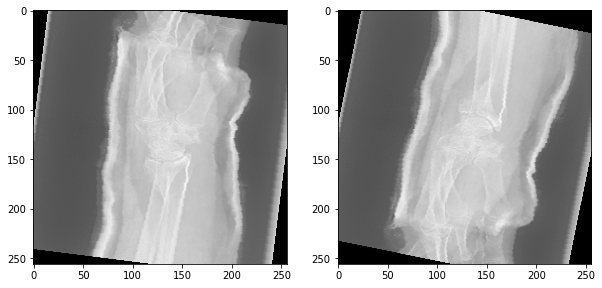

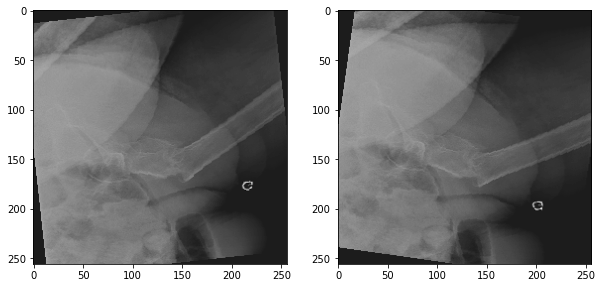

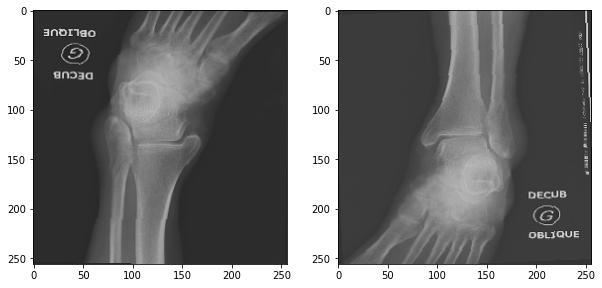

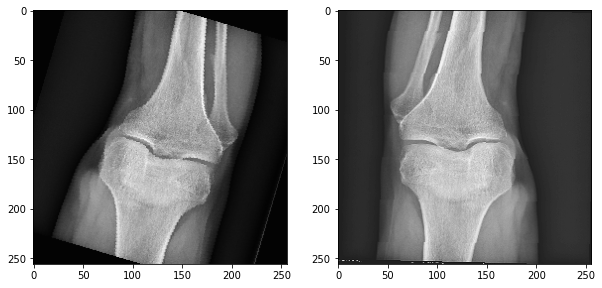

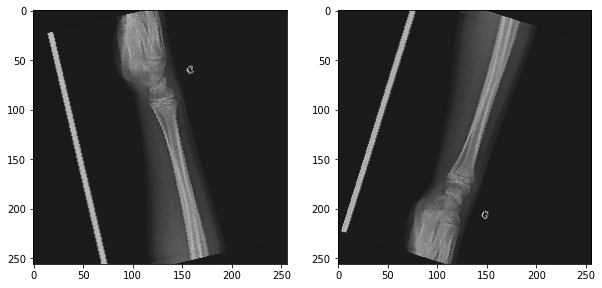

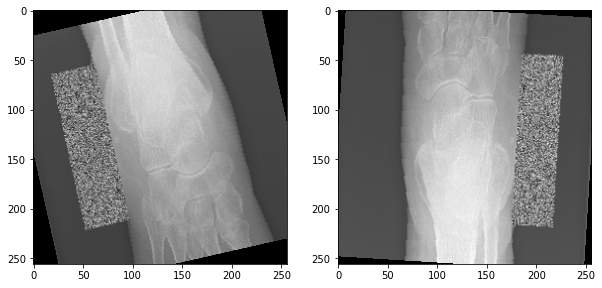

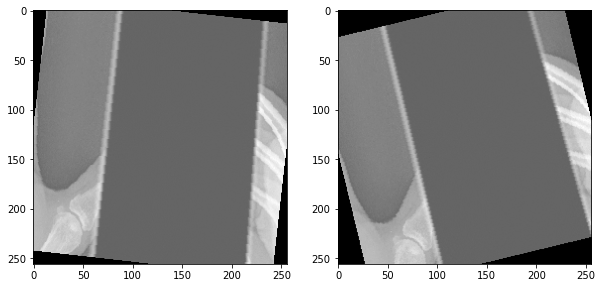

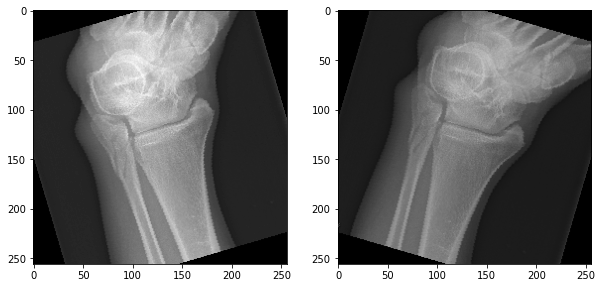

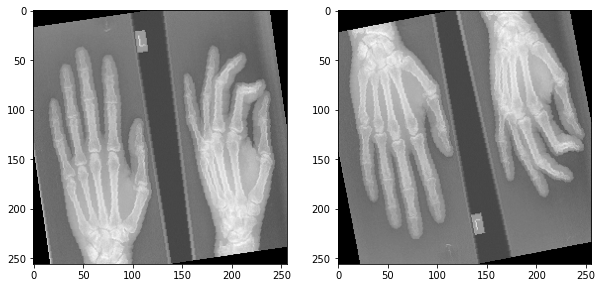

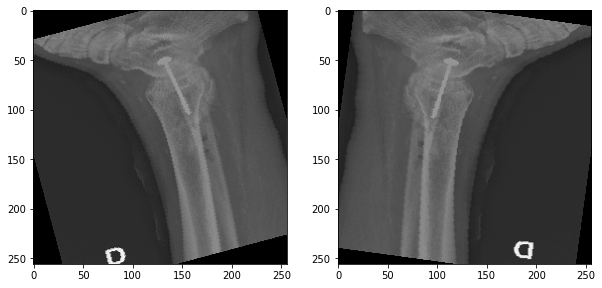

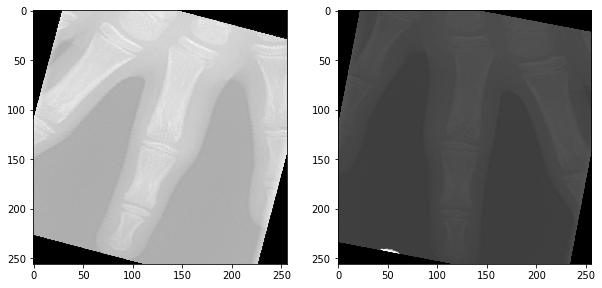

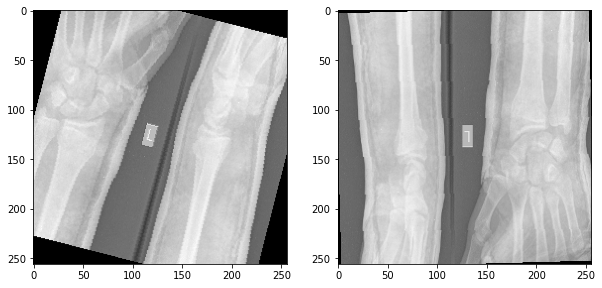

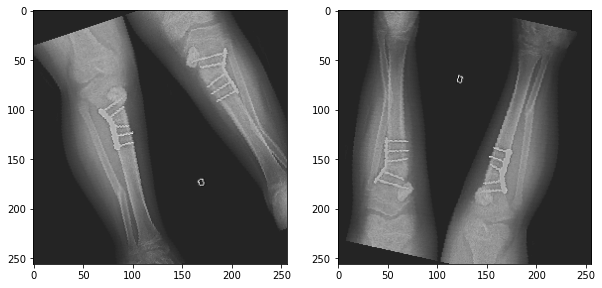

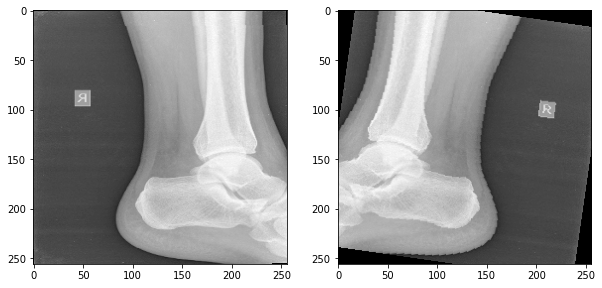

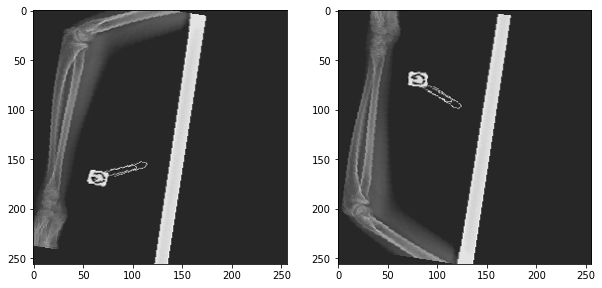

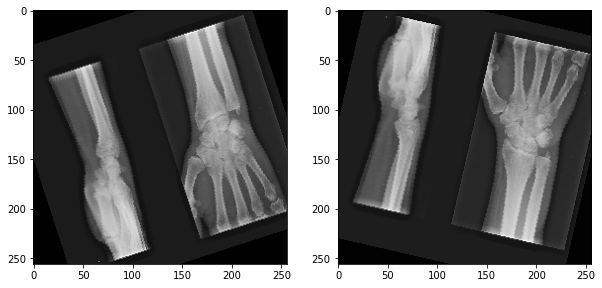

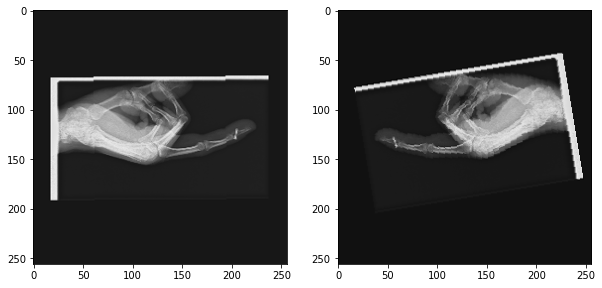

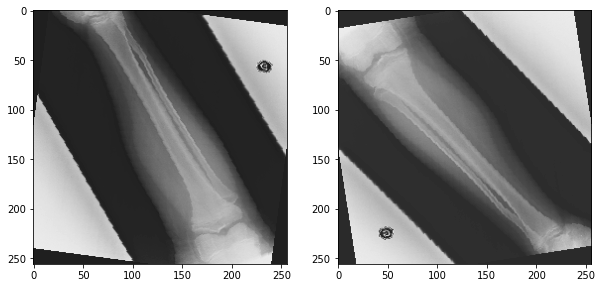

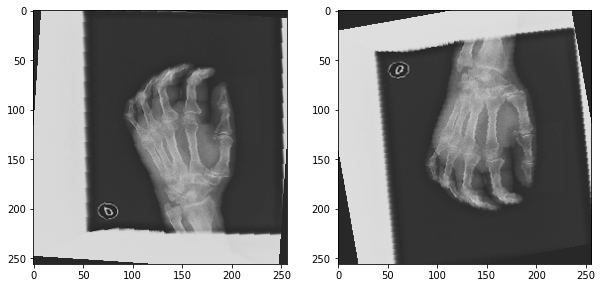

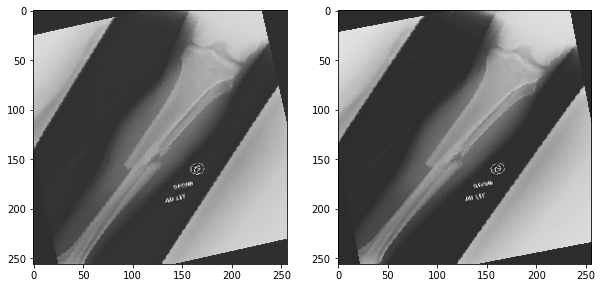

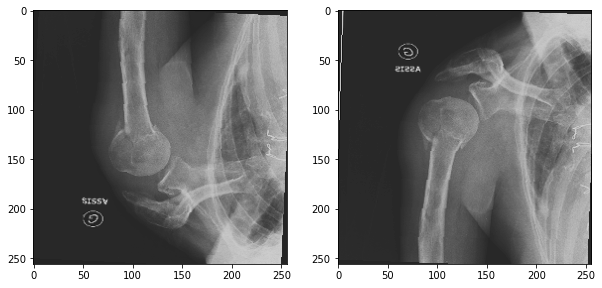

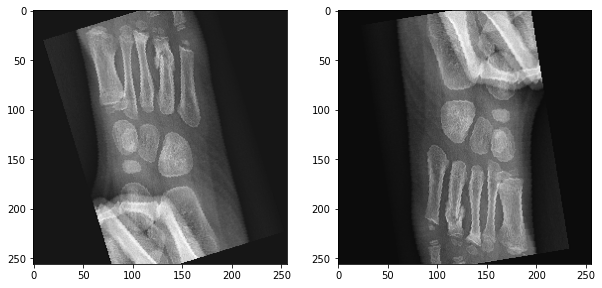

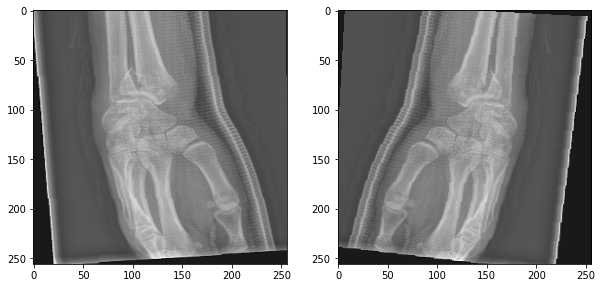

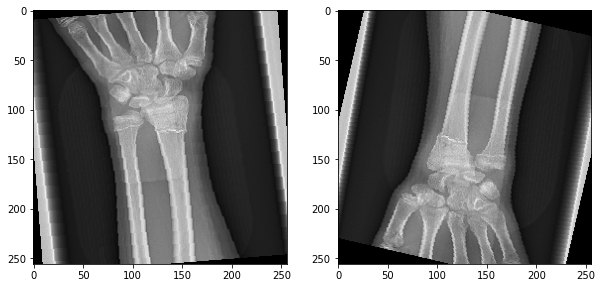

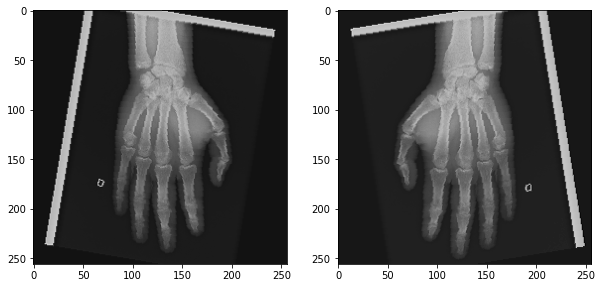

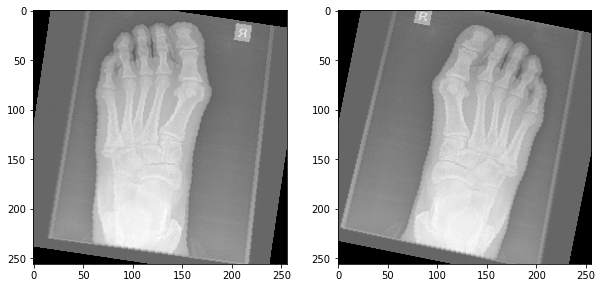

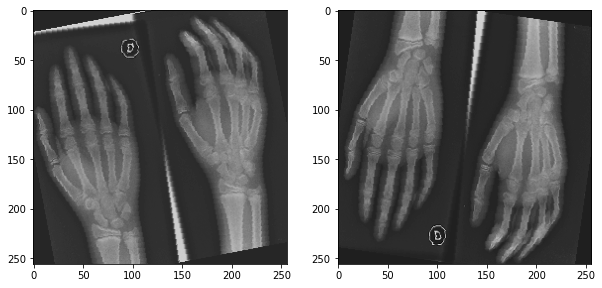

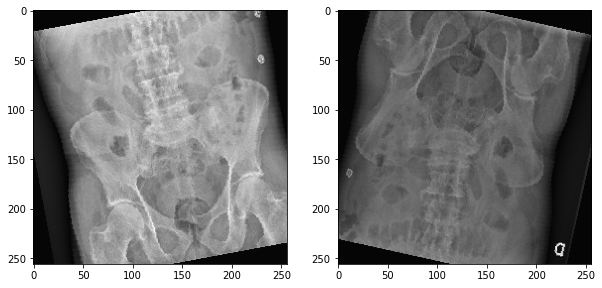

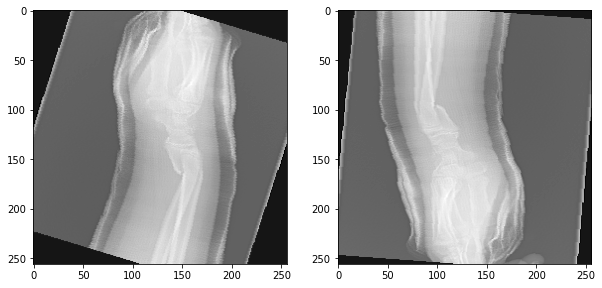

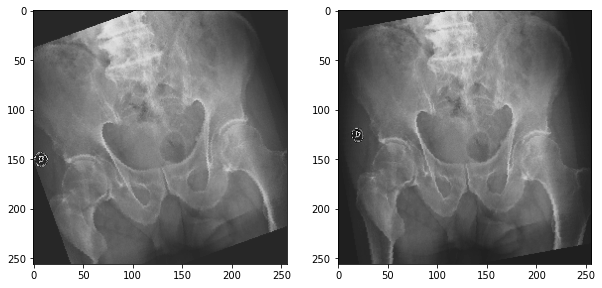

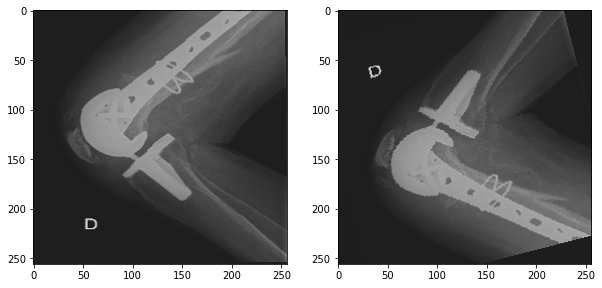

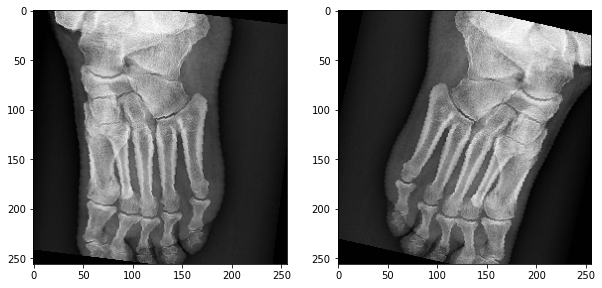

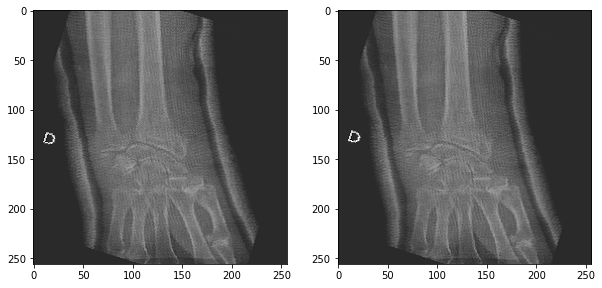

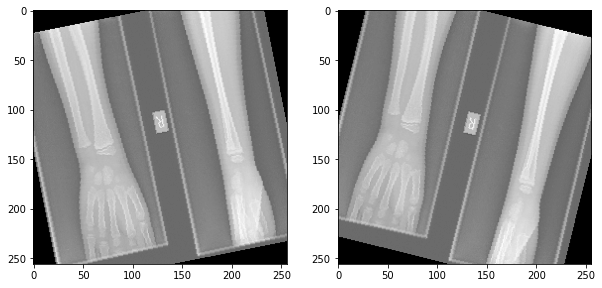

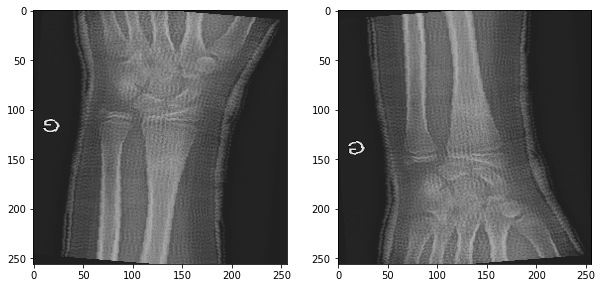

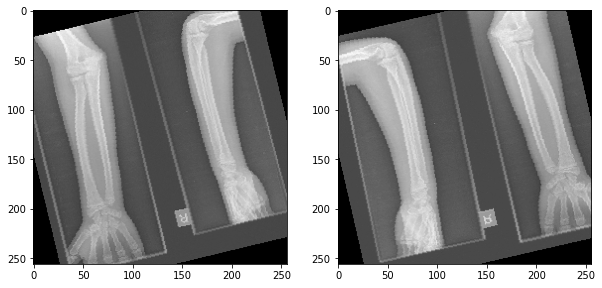

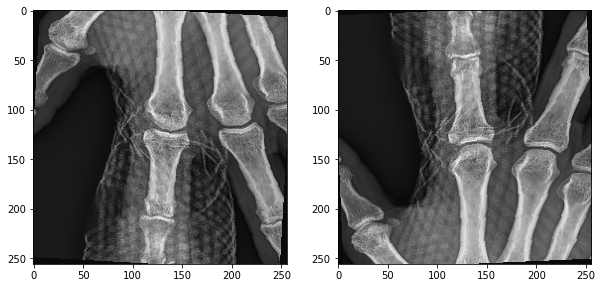

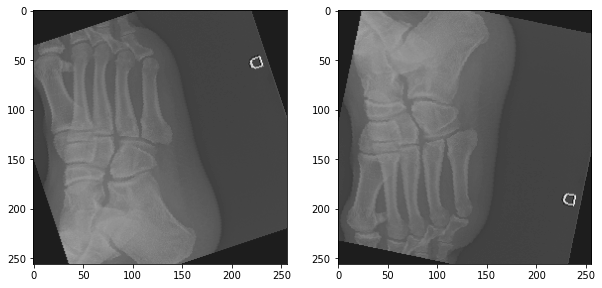

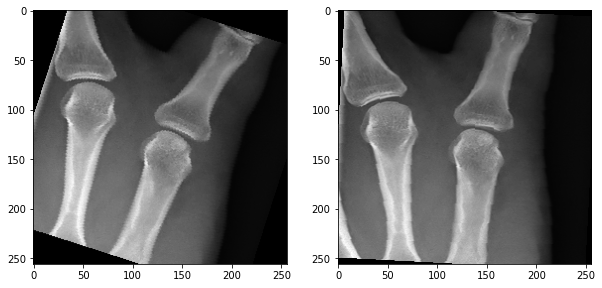

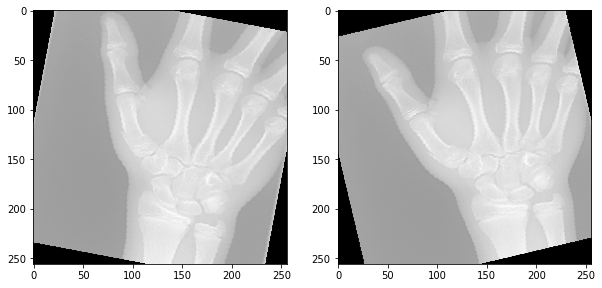

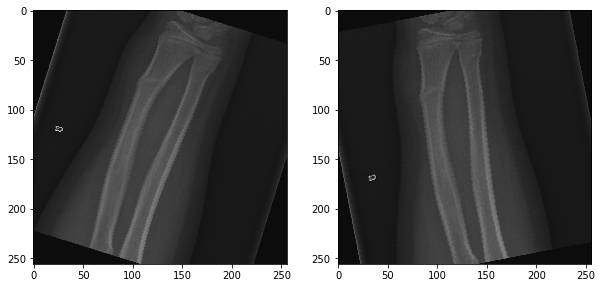

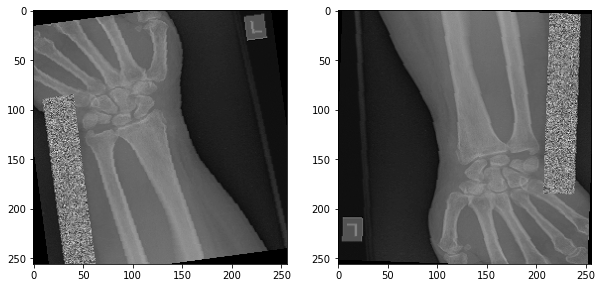

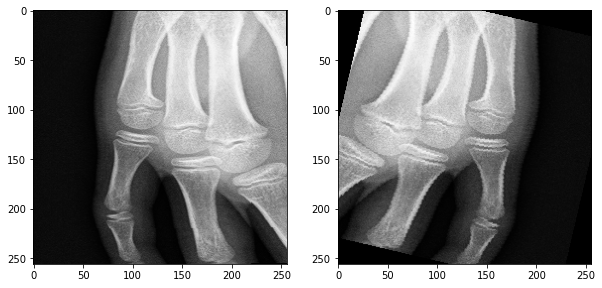

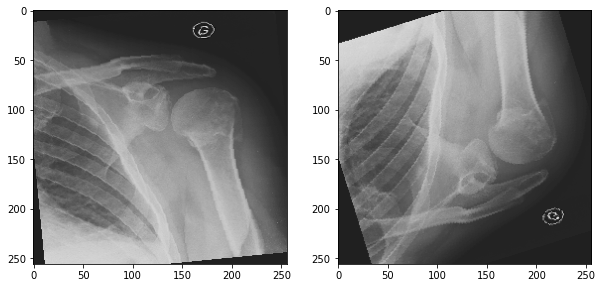

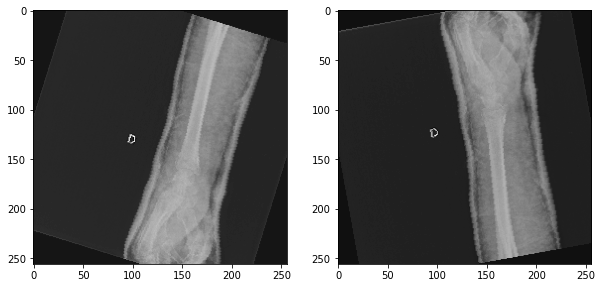

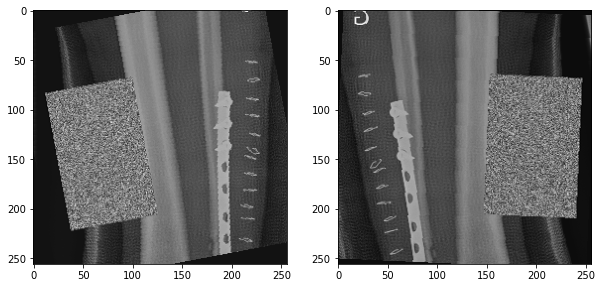

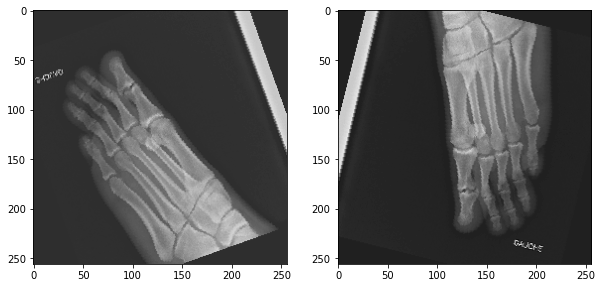

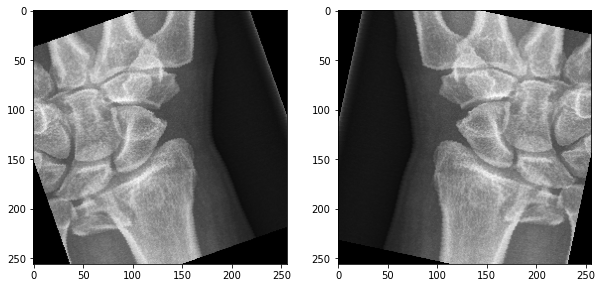

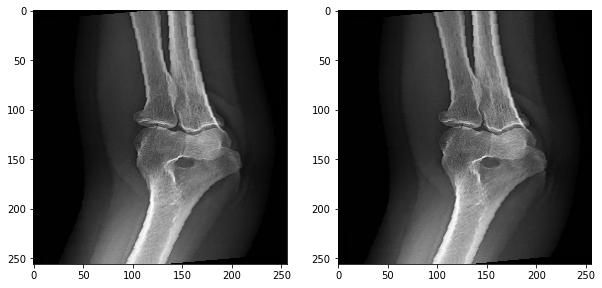

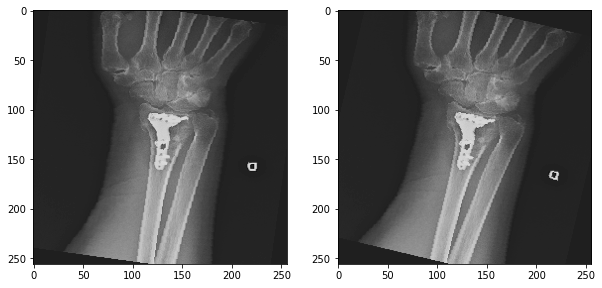

In [66]:
for i in np.random.choice(range(len(dataset)), 50, replace=False):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    pair = dataset[i]['img']
    v1, v2 = pair
    axes[0].imshow(v1[0], cmap='gray')
    axes[1].imshow(v2[0], cmap='gray')    

In [25]:
model = build_model(cfg.model)

In [29]:
pair.unsqueeze(0).shape

torch.Size([1, 2, 3, 256, 256])

In [70]:
imgs = next(iter(dataloader))
imgs = imgs['img']
with torch.no_grad():
    res = model.forward(imgs)
print(res)

{'loss': tensor(0.1036)}


# Compare results from OpenSelfSup vs Lucidrains

In [184]:
from byol_pytorch import BYOL
from torchvision import models, transforms
import torch.nn.functional as F
from torch import nn

In [73]:
resnet = models.resnet50(pretrained=False)

In [74]:
byol_lucid = BYOL(
        resnet,
        image_size = 256,
        hidden_layer = 'avgpool', # mettre feat5 comme OpenSelfSup ?
        projection_size = 256,
        projection_hidden_size = 4096,
        moving_average_decay = 0.99
)

In [75]:
byol_oss = build_model(cfg.model)

In [101]:
with torch.no_grad():
    res_oss = byol_oss(pairs)

In [102]:
res_oss

{'loss': tensor(0.1563)}

tensor(3.9778, grad_fn=<MeanBackward0>)

In [107]:
resnet_state_dict = byol_lucid.net.state_dict()

In [111]:
byol_oss.online_net[0].load_state_dict(resnet_state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])

In [115]:
pairs = torch.rand(4, 2, 3, 256, 256)
v1 = pairs[:, 0, ...]
v2 = pairs[:, 1, ...]
with torch.no_grad():
    res_oss = byol_oss(pairs)
    res_lucid = byol_lucid((v1, v2))    

In [ ]:
with torch.no_grad():
    res_oss = byol_oss(pairs)
    res_lucid = byol_lucid((v1, v2))  

In [139]:
with torch.no_grad():
    features_oss = byol_oss.online_net[0](v1)

In [140]:
with torch.no_grad():
    features_lucid = nn.Sequential(*list(byol_lucid.net.children())[:-2])(v1)

In [142]:
torch.equal(features_oss[0], features_lucid)

True

In [158]:
byol_oss.online_net[-1]

NonLinearNeckSimCLR(
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (relu): ReLU(inplace=True)
  (fc0): Linear(in_features=2048, out_features=4096, bias=True)
  (bn0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
)

In [164]:
byol_lucid.online_predictor

MLP(
  (net): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=4096, out_features=256, bias=True)
  )
)

In [170]:
match_projector = [
    (byol_oss.online_net[-1].fc0, byol_lucid.online_encoder.projector.net[0]),
    (byol_oss.online_net[-1].bn0, byol_lucid.online_encoder.projector.net[1]),
    (byol_oss.online_net[-1].fc1, byol_lucid.online_encoder.projector.net[3]),
]

match_predictor = [
    (byol_oss.head.predictor.fc0, byol_lucid.online_predictor.net[0]),
    (byol_oss.head.predictor.bn0, byol_lucid.online_predictor.net[1]),
    (byol_oss.head.predictor.fc1, byol_lucid.online_predictor.net[3]),
]


for (oss, lucid) in match_projector:
    for parameter_oss, parameter_lucid in zip(oss.parameters(), lucid.parameters()):
        parameter_oss.data = parameter_lucid
        
for (oss, lucid) in match_predictor:
    for parameter_oss, parameter_lucid in zip(oss.parameters(), lucid.parameters()):
        if parameter_oss.shape != parameter_lucid.shape:
            print('oups')
        parameter_oss.data = parameter_lucid

In [171]:
pairs = torch.rand(4, 2, 3, 256, 256)
v1 = pairs[:, 0, ...]
v2 = pairs[:, 1, ...]
with torch.no_grad():
    res_oss = byol_oss(pairs)
    res_lucid = byol_lucid((v1, v2))    

# inference lucid

In [198]:
def loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 * (x * y).sum(dim=-1)

In [199]:
image_one, image_two = (v1, v2)

with torch.no_grad():
    online_proj_one, _ = byol_lucid.online_encoder(image_one)
    online_proj_two, _ = byol_lucid.online_encoder(image_two)

    online_pred_one = byol_lucid.online_predictor(online_proj_one)
    online_pred_two = byol_lucid.online_predictor(online_proj_two)

with torch.no_grad():
    target_encoder = byol_lucid._get_target_encoder() if byol_lucid.use_momentum else byol_lucid.online_encoder
    target_proj_one, _ = target_encoder(image_one)
    target_proj_two, _ = target_encoder(image_two)
    target_proj_one.detach_()
    target_proj_two.detach_()
    
loss_one = loss_fn(online_pred_one, target_proj_two.detach())
loss_two = loss_fn(online_pred_two, target_proj_one.detach())

loss = loss_one + loss_two

In [201]:
loss.mean()

tensor(0.0337)

# inference oss

In [177]:
img = pairs

img_v1 = img[:, 0, ...].contiguous()
img_v2 = img[:, 1, ...].contiguous()

with torch.no_grad():
    proj_online_v1 = byol_oss.online_net(img_v1)[0]
    proj_online_v2 = byol_oss.online_net(img_v2)[0]
with torch.no_grad():
    proj_target_v1 = byol_oss.target_net(img_v1)[0].clone().detach()
    proj_target_v2 = byol_oss.target_net(img_v2)[0].clone().detach()

In [181]:
proj_target_v1, proj_target_v2

(tensor([[ 0.2388,  0.2846,  2.1640,  ..., -0.5017, -0.9759, -0.3176],
         [ 0.6911,  2.2514, -0.6153,  ...,  1.6900,  0.0778, -2.1365],
         [-0.4477,  1.2449,  0.2607,  ...,  1.8270, -0.2551, -0.2848],
         [ 2.0502,  1.3437, -0.1946,  ..., -0.4036,  0.0059, -2.4431]]),
 tensor([[ 1.4623,  1.9397, -0.3607,  ...,  0.9100,  0.7247, -1.9642],
         [-0.0277,  0.8240,  0.4022,  ...,  1.9429,  0.1296, -0.1022],
         [ 0.5539,  1.3034,  1.2678,  ..., -0.0796, -0.8517, -1.8352],
         [ 0.5011,  1.0943,  0.6423,  ..., -0.1296, -1.0251, -1.5088]]))

In [197]:
(loss_fn(proj_online_v1, proj_target_v2) + loss_fn(proj_online_v2, proj_target_v1)).mean()

tensor(-0.0221)

In [192]:
def loss_oss(pred, target):
    pred_norm = nn.functional.normalize(pred, dim=1)
    target_norm = nn.functional.normalize(target, dim=1)
    loss = -2 * (pred_norm * target_norm).sum()
    return loss
#     loss /= input.size(0)

In [193]:
loss_oss(proj_online_v1, proj_target_v2)

tensor(0.0085)

In [207]:
checkpoint = torch.load('/media/nas/experiment_weights/ssl/openselfsup/r50_256_bs32_ep300_latest.pth', map_location='cpu')

In [208]:
checkpoint

{'state_dict': {'conv1.weight': tensor([[[[-3.8850e-02, -8.8760e-04,  2.9548e-01,  ...,  2.6839e-02,
              9.5348e-04, -9.7242e-02],
            [-1.6114e-01, -8.8360e-02, -9.9284e-02,  ..., -5.5907e-02,
              1.3149e-01, -6.2137e-02],
            [ 3.5378e-02,  3.0152e-02,  8.8656e-02,  ...,  7.7527e-03,
             -2.8566e-02, -1.4885e-01],
            ...,
            [ 5.5909e-02,  2.1864e-01, -8.4789e-02,  ...,  1.9883e-02,
             -1.4403e-01, -1.8311e-01],
            [-2.8014e-03,  2.8890e-01,  2.6941e-02,  ...,  2.6379e-03,
             -1.9883e-01, -5.5592e-02],
            [ 3.7414e-01,  1.9224e-02,  1.2473e-01,  ..., -2.0921e-01,
              8.9826e-03, -3.6694e-01]],
  
           [[ 1.6495e-01, -1.4152e-01, -1.0183e-01,  ...,  2.2710e-01,
              4.1561e-02,  5.0925e-02],
            [ 1.2812e-01,  4.0569e-02,  1.0934e-01,  ...,  1.2129e-02,
             -4.2223e-02, -4.2742e-02],
            [-9.3620e-02,  1.5688e-02, -2.5200e-01,  ..., -7.